# 손 숫자 구현: 모델 선택 및 변환

> ### 드라이브 마운트

In [1]:
from google.colab import drive
drive.mount('/content/drive')
save_dir = '/content/drive/My Drive/files/save/'

Mounted at /content/drive


>### Load modules

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import cv2
from sklearn.model_selection import train_test_split

print("Module Loaded.")
print("NumPy Version :{}".format(np.__version__))
print("TensorFlow Version :{}".format(tf.__version__))
print("Matplotlib Version :{}".format(plt.matplotlib.__version__))

Module Loaded.
NumPy Version :1.18.5
TensorFlow Version :2.3.0
Matplotlib Version :3.2.2


> ### Load 손 숫자 Data

In [3]:
!unzip -q -o /content/drive/My\ Drive/files/Sign-Language-Digits-Dataset-master.zip

In [4]:
% cd /content/Sign-Language-Digits-Dataset-master
% ls

/content/Sign-Language-Digits-Dataset-master
Dataset/  Examples/  LICENSE  README.md


In [5]:
IMG_SIZE = 64
first = True
for ind in range(0, 10, 1) :
  path = './Dataset/' + str(ind) + '/*.*'
  print(path)
  files = glob.glob(path)
  tmpx = np.array([(cv2.resize(cv2.cvtColor(cv2.imread(x, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB), (IMG_SIZE,IMG_SIZE))) for x in files])
  tmpy = np.array([ind] * len(files))
  xtrain, xtest, ytrain, ytest = train_test_split(tmpx, tmpy, test_size=0.2, random_state=123)
  if first == True:
    train_data = xtrain.copy()
    train_labels = ytrain.copy()
    test_data = xtest.copy()
    test_labels = ytest.copy()
    first = False
  else :
    train_data = np.concatenate((train_data, xtrain))
    train_labels = np.concatenate((train_labels, ytrain))
    test_data = np.concatenate((test_data, xtest))
    test_labels = np.concatenate((test_labels, ytest))

./Dataset/0/*.*
./Dataset/1/*.*
./Dataset/2/*.*
./Dataset/3/*.*
./Dataset/4/*.*
./Dataset/5/*.*
./Dataset/6/*.*
./Dataset/7/*.*
./Dataset/8/*.*
./Dataset/9/*.*


In [6]:
train_data = train_data.astype(np.double)
train_data = train_data / 255.0

test_data = test_data.astype(np.double)
test_data = test_data / 255.0

print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(1645, 64, 64, 3)
(1645,)
(417, 64, 64, 3)
(417,)


>### Create Model


In [7]:
model = tf.keras.models.Sequential()
model.add(tf.keras.applications.densenet.DenseNet121(
    weights="imagenet", 
    include_top=False,    # dense layer 이 후는 제외
    input_tensor=tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    ))
# Dense layers
model.add(tf.keras.layers.Flatten(name='flatten'))
model.add(tf.keras.layers.Dense(1024, activation='relu',name='dense_1024'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(10, activation='softmax', name='dense_10'))

model.summary()

29089792/29084464 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 2, 2, 1024)        7037504   
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense_1024 (Dense)           (None, 1024)              4195328   
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dense_10 (Dense)             (None, 10)                10250     
Total params: 11,247,178
Trainable params: 11,161,482
Non-trainable params: 85,696
_________________________________________________________________


###Compile Model

In [8]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

> ### 학습 전 상황

In [9]:
def Make_Result_Plot(suptitle:str, data:np.ndarray, label:np.ndarray, y_max:np.ndarray):
    fig_result, ax_result = plt.subplots(2,5,figsize=(18, 7))
    fig_result.suptitle(suptitle)
    for idx in range(10):
        ax_result[idx//5][idx%5].imshow(data[idx*40+40].reshape((IMG_SIZE,IMG_SIZE, 3)),cmap="binary")
        ax_result[idx//5][idx%5].set_title("test_data[{}] (label : {} / y : {})".format(idx*40+40, label[idx*40+40], y_max[idx*40+40]))

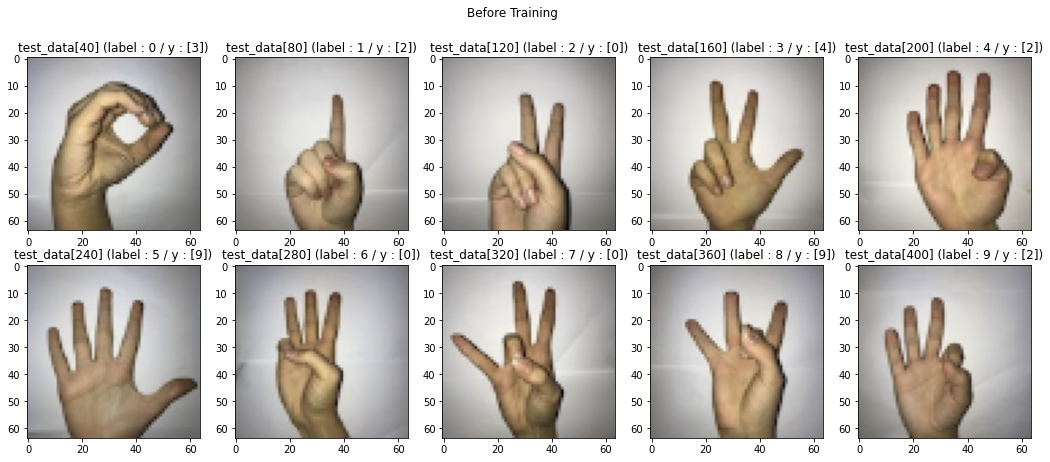

In [10]:
y_out = model.predict(test_data)
y_max = np.argmax(y_out, axis=1).reshape((-1, 1))
Make_Result_Plot("Before Training", test_data, test_labels, y_max)

> ### 학습 (Training)

In [11]:
%%time
history = model.fit(train_data, train_labels, 
                        shuffle=True,
                        batch_size=128, 
                        epochs=20,
                        validation_data=(test_data, test_labels))

Epoch 1/20
13/13 [==============================] - 99s 8s/step - loss: 0.9099 - accuracy: 0.7252 - val_loss: 30.9272 - val_accuracy: 0.2110
Epoch 2/20
13/13 [==============================] - 96s 7s/step - loss: 0.1004 - accuracy: 0.9641 - val_loss: 35.1917 - val_accuracy: 0.2278
Epoch 3/20
13/13 [==============================] - 95s 7s/step - loss: 0.0386 - accuracy: 0.9903 - val_loss: 14.9393 - val_accuracy: 0.3165
Epoch 4/20
13/13 [==============================] - 95s 7s/step - loss: 0.0195 - accuracy: 0.9921 - val_loss: 8.9917 - val_accuracy: 0.5707
Epoch 5/20
13/13 [==============================] - 99s 8s/step - loss: 0.0337 - accuracy: 0.9909 - val_loss: 4.8462 - val_accuracy: 0.7050
Epoch 6/20
13/13 [==============================] - 95s 7s/step - loss: 0.0135 - accuracy: 0.9964 - val_loss: 2.8308 - val_accuracy: 0.7578
Epoch 7/20
13/13 [==============================] - 95s 7s/step - loss: 0.0097 - accuracy: 0.9970 - val_loss: 3.1028 - val_accuracy: 0.7314
Epoch 8/20
13/13 

> ### Ploting : Cost/Training Count

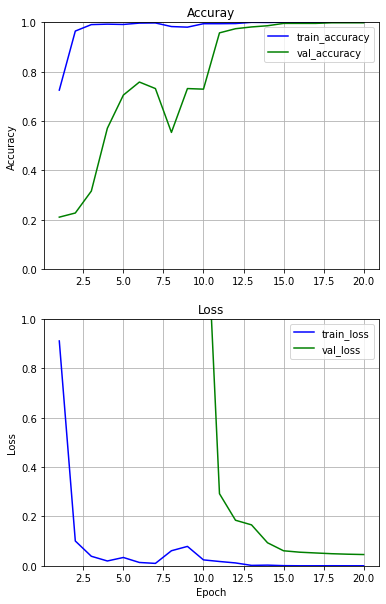

In [12]:
loss = history.history['loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(6, 10))
plt.subplot(2, 1, 1)
plt.title('Accuray')
plt.plot(epochs, history.history['accuracy'], 'b', label='train_accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'g', label='val_accuracy')
plt.ylim([0,1])
plt.grid(True)
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.subplot(2, 1, 2)
plt.title('Loss')
plt.plot(epochs, history.history['loss'], 'b', label='train_loss')
plt.plot(epochs, history.history['val_loss'], 'g', label='val_loss')
plt.ylim([0,1])
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

> ### Training 이후

In [13]:
print(np.max(history.history['val_accuracy']))

0.9976019263267517


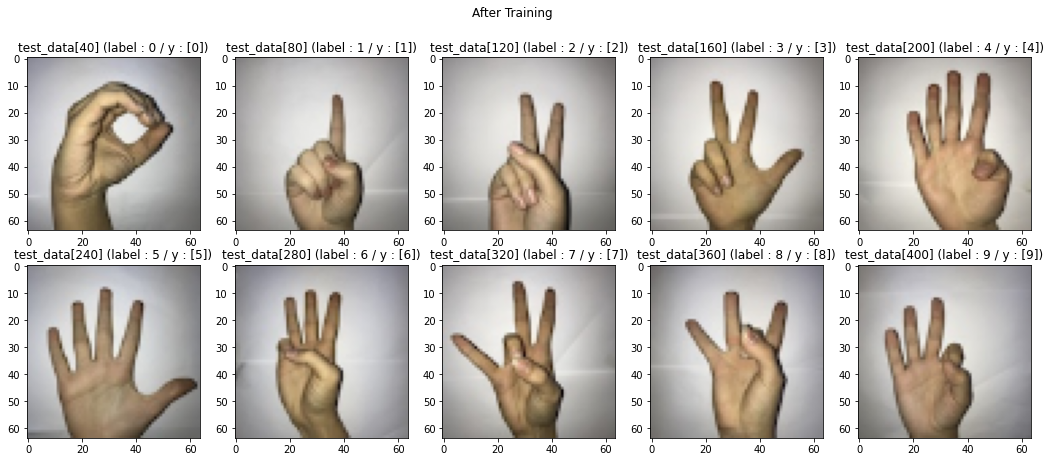

In [14]:
y_out = model.predict(test_data)
y_max = np.argmax(y_out, axis=1).reshape((-1, 1))
Make_Result_Plot("After Training", test_data, test_labels, y_max)

> ### 모델을 TFLite로 변환

In [15]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpd18p1_6n/assets


> ### 파일로 저장

In [16]:
open(save_dir + 'sign.tflite', 'wb').write(tflite_model)

44730112